# Identifying network metrics that can distinguish biased citation networks

Author: Yuanxi Fu, Zhonghe Wan

Date: 2021-7-5

## Introduction

This notebook records an attempt to realize the idea we proposed in the CRB proposal: https://docs.google.com/document/d/1yo9_zd4YlRLKQTQSSJn_dYCfl4YPGyYA2wb65DkCu4s/edit. In particular, we wanted to construct a program to simulate unbiased counter part for observed biased citation network and use statistical testing to identify network metrics that can distinguish biased networks. Also, with improved algorithm to calculate the expected citation counts, we can improve the work in the ISSI paper. 

>  The overall goal is to choose a network metric η that can distinguish biased citation networks (e.g., Table 1) from simulated, unbiased networks. To do this, I will follow established procedures for assessing the significance of network characteristics (Kolaczyk & Csárdi, 2020):  gather existing biased networks; generate an ensemble of simulated networks that mimic unbiased citation behavior; choose an initial network metric η and compute the value of η on the reported biased citation network to get ηobs and a set of model-generated unbiased networks to get {ηmodel}. With the distribution from {ηmodel}, we will be able to test whether η is significantly different between biased and unbiased networks (i.e., ηobs very unlikely to exist given the distribution of {ηmodel}). 

## Load packages

In [15]:
import pandas as pd
from igraph import * # install igraph in anaconda: https://anaconda.org/conda-forge/python-igraph
import cairo # install cairo and pychairo in anaconda: https://anaconda.org/anaconda/cairo; https://anaconda.org/anaconda/pycairo 
import numpy as np
import numpy.random as random
import math
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from statistics import stdev
import scipy.stats

## Load data

We will use the following dataset of a biased ciation network:

de Vries, Ymkje Anna, & Munafò, M. (2016). [Dataset] Citation bias and selective focus on positive findings in the literature on 5-HTTLPR, life stress, and depression. University of Bristol. Retrieved January 28, 2021, http://doi.org/10.5523/BRIS.Z7JCONXFBMDR1JJ3T0W4K1HWN

In [16]:
# load the adjacency matrix
matrix = pd.read_csv('HTTLPR.csv')
matrix = matrix.iloc[:, 6:]
matrix

,Mossner,Caspi,Eley,Grabe_a,Kaufman_a,Gillespie,Kendler,Surtees,Sjoberg,Nakatani,...,Comasco_a,Cicchetti_b,Jenness,Scheid_b,Quinn,Grabe_b,Petersen,Beaver,Brown,Wilhelm_b
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-,X,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-,X,-,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-,X,-,X,-,-,X,-,X,-,...,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN
69,-,X,X,-,-,-,X,X,X,-,...,-,-,-,-,-,-,NaN,NaN,NaN,NaN
70,-,X,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,NaN,NaN,NaN
71,-,X,X,-,-,-,-,-,X,-,...,-,-,-,-,-,-,-,-,NaN,NaN


In [17]:
# load the attribute list
# easy for this file because the first 6 columns are in fact attribute list
attr_list = pd.read_csv('HTTLPR.csv', usecols=[0, 1, 2, 3, 4, 5])
attr_list['PaperID'] = attr_list.index

## Create a graph object g from the citation network data

In [18]:
# initialize the graph object
g = Graph(directed=True)
g.add_vertices(73)

# add attributes to the graph: study name: name; study outcome: outcome; YearOnline: year
# study = attr_list['Study'].to_list()
# outcome = attr_list['Outcome'].to_list()
g.vs['name'] = attr_list['Study']
g.vs["label"] = g.vs["name"]
g.vs['outcome'] = attr_list['Outcome']
g.vs['Year'] = attr_list['YearOnline']
g.vs['color'] = 'light blue'

# add edges from the adjacency matrix
edge_list = []
for i in range(0, matrix.shape[0]):
    for j in range(0, matrix.shape[1]):
        if isinstance(matrix.iloc[i, j], str):
            s = matrix.iloc[i, j]
            if s.replace(" ", "") == "X":
                edge_list.append((i, j))
                g.add_edge(source=i, target=j)

In [19]:
# total number of edges
len(g.es)

488

In [20]:
# visualization
vis = plot(g,layout="kk", margin=50,bbox=(600,600),vertex_label_size=10,edge_arrow_size=0.5,edge_arrow_width=1.5)
vis.show()

## Create a "potential graph"

Create a "potential graph" (g_full) for the 5-HTTLPR in which all "potential citation paths" (Urlings et al., 2021) are connected . In our definition, a "potential citation path" exists between two publication if one paper is published one year or more earlier than another paper.

In [21]:
# potential graph
year_gap = 1

g_full = Graph(directed=True)
g_full.add_vertices(73)
g_full.vs['name'] = attr_list['Study']
g_full.vs["label"] = g_full.vs["name"]
g_full.vs['outcome'] = attr_list['Outcome']
g_full.vs['Year'] = attr_list['YearOnline']

full_edge_list=[]

for i in g_full.vs.indices:
    for j in g_full.vs.indices:
        if i>j and (g.vs[i]['Year']-g.vs[j]['Year']>=year_gap):
            full_edge_list.append((i,j))
            g_full.add_edge(source=i,target=j)

In [22]:
# number of edges in g_full
len(g_full.es)

2348

## Compute p(y)

Each paper in this dataset faces a pool of papers to choose from to cite ("potential references"). Under our definition, such a pool consists of papers published one year or more earlier than the citing paper. In the real world, the authors may be biased (i.e., they select a non-representative sample from the pool to cite). In this simulation, we will try to remove such a bias. We will compute p(y), number of performed citations divided by the total number of potential citations between papers published in year y and their pool of potential references. Using a Bernoulli random number generator, we will distribute the chance evenly among all potential references (i.e., each paper will enjoy an equal chance of p(y) to be cited). 

In [23]:
generations = pd.unique(g.vs['Year'])
generations

array([2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [24]:
performed_citation = [len(g.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
performed_citation

[0, 0, 4, 13, 38, 81, 52, 81, 85, 91, 43]

In [25]:
potential_citation = [len(g_full.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
potential_citation

[0, 1, 8, 24, 80, 198, 232, 407, 336, 660, 402]

### The first generation (2001) has no performed citation and no potential citation. Replace p(y) with NaN

In [26]:
p_y = [i/j for i, j in zip(performed_citation[1:], potential_citation[1:])]
p_y = [None] + p_y
p_y

[None,
 0.0,
 0.5,
 0.5416666666666666,
 0.475,
 0.4090909090909091,
 0.22413793103448276,
 0.19901719901719903,
 0.25297619047619047,
 0.13787878787878788,
 0.10696517412935323]

In [27]:
prob = pd.DataFrame({'year': generations,
                    'performed_citation': performed_citation,
                    'potential_citation': potential_citation,
                    'p(y)': p_y})
prob

,year,performed_citation,potential_citation,p(y)
0,2001,0,0,NaN
1,2003,0,1,0.000000
2,2004,4,8,0.500000
3,2005,13,24,0.541667
4,2006,38,80,0.475000
5,2007,81,198,0.409091
6,2008,52,232,0.224138
7,2009,81,407,0.199017
8,2010,85,336,0.252976
9,2011,91,660,0.137879


**NOTE**: p(y) first increases and then decreases over the years.

## Use p(y) to simulate unbiased networks

To construct one instance of unbiased network, we will run a bernoulli process (coin-flip) using the p(y) as the sole input parameter to generate a vector that describes which potential citation paths are connected (1) and which are not (0) for one generation of paper. This is in fact quite like Greenberg's "network rearrangement." We rearranged the network so that citations are evenly distributed among papers, without the awareness about their positions. 

In [28]:
random.seed(0)

# intialize values
expected_citation_df = pd.DataFrame({'node':g_full.vs['name'],'degree':0})

draw = 1000

for p in range(draw):
    
    # initialize the graph
    g_sim=Graph(directed=True)
    g_sim.add_vertices(73)
    g_sim.vs['Year'] = attr_list['YearOnline']
    
    edge_df = g_full.get_edge_dataframe()
    edge_df['source_year'] = [g_sim.vs(x)['Year'][0] for x in edge_df['source']]
    edge_df['target_year'] = [g_sim.vs(x)['Year'][0] for x in edge_df['target']]
    edge_df['mask'] = None
    
    # produce the mask, randomly generated vector obey Bernoulli distribution and p(y)
    for year in generations[1:]:
        p_y = prob.loc[prob['year'] == year,'p(y)']
        potential_citation = prob.loc[prob['year'] == year,'potential_citation']
        citation_vector = bernoulli.rvs(p_y,size=potential_citation)
        edge_df.loc[edge_df['source_year'] == year,'mask'] = citation_vector
    
    # add edges to g_sim
    edge_df = edge_df.loc[edge_df['mask'] == 1, ('source','target')]
    g_sim.add_edges(list(zip(edge_df['source'],edge_df['target'])))
    
    # commpute network metrics
    expected_citation_df['degree'] = expected_citation_df['degree'] + g_sim.degree(mode=IN)

if p == draw - 1:
    print("complete the simulation for", p+1, "times.")


complete the simulation for 1000 times.


In [29]:
expected_citation_df['degree'] = expected_citation_df['degree']/draw
expected_citation_df

,node,degree
0,Mossner,20.483
1,Caspi,20.633
2,Eley,18.504
3,Grabe_a,18.566
4,Kaufman_a,18.612
...,...,...
68,Grabe_b,0.000
69,Petersen,0.000
70,Beaver,0.000
71,Brown,0.000


## Improve the ISSI work with better "expected citation counts"

In [30]:
degree_ratio = pd.DataFrame(columns=['paperID','degree_ratio'])
g_degree = pd.Series(g.degree(mode=IN))
last_generation = []

for idx, degree in enumerate(g_degree):
    if g_degree[idx]!=0:
        degree_ratio = degree_ratio.append({'paperID': idx, 'degree_ratio': round(g_degree[idx] / expected_citation_df.iloc[idx,1],3)},
                            ignore_index=True)
    else:
        last_generation.append(idx) # not suppose to have citations because of the constructs

In [31]:
# max
degree_ratio['degree_ratio'].max()

3.15

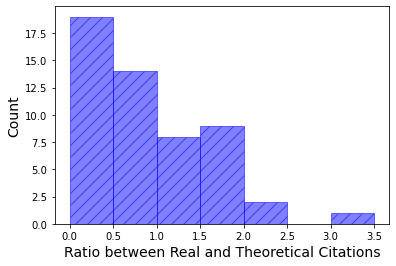

In [32]:
bins = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5]
plt.hist(degree_ratio['degree_ratio'], bins=bins,color='blue', edgecolor='blue', linewidth=1, hatch="//",
         histtype='bar', alpha=0.5)
plt.xlabel('Ratio between Real and Theoretical Citations',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

In [33]:
low_cutoff = 0.3
high_cutoff = 0.9
idx_low = degree_ratio[degree_ratio['degree_ratio'] < low_cutoff].index.tolist()
idx_low = [int(item) for item in idx_low]

idx_high = degree_ratio[degree_ratio['degree_ratio'] > high_cutoff].index.tolist()
idx_high = [int(item) for item in idx_high]

In [34]:
# network visualization
for node in g.vs.indices:
    if node in idx_low:
        g.vs[node]['citation_ratio'] = 'Low'
    elif node in idx_high:
        g.vs[node]['citation_ratio'] = 'High'
    elif node in last_generation:
        g.vs[node]['citation_ratio'] = 'Last Generation'
    else:
        g.vs[node]['citation_ratio'] = 'Average'

color_dict = {"High": "green", "Low": "pink", "Average": "light blue","Last Generation":"white"}
g.vs["color"] = [color_dict[ratio] for ratio in g.vs["citation_ratio"]]
plot(g,bbox=(600,600),margin=50,layout="kk",vertex_label_size=10,edge_arrow_size=0.5,edge_arrow_width=1.5).show()

In [35]:
# print out paper with low ratio between real and expected citation counts
for node in idx_low:
    print(g.vs[node]['name'],g.vs[node]['Year'],g.vs[node]['outcome'])

Mossner 2001 Positive
Dick 2007 Unclear
Kraus 2007 Negative
Kilpatrick 2007 Unclear
Lotrich 2008 Unclear
Aguilera 2009 Positive
Benjet 2009 Positive
Hammen 2009 Unclear


## Improve the ISSI work with better "relative evidence coupling strength"

In [36]:
# initialize the data storage
coupling_strength = pd.DataFrame(columns=['node_1','node_2','ratio'])

# looping through each pair in the net
for node_1_ix in g.vs.indices:
    for node_2_ix in g.vs.indices:
        if node_2_ix > node_1_ix:
            node_1 = g.vs[node_1_ix]
            node_2 = g.vs[node_2_ix]
            node_1_set = set(g.neighbors(node_1, mode=OUT))
            node_2_set = set(g.neighbors(node_2, mode=OUT))
            if (len(node_1_set) + len(node_2_set)) != 0:
                strength = len(node_1_set.intersection(node_2_set)) / (
                        len(node_1_set) + len(node_2_set) - len(
                    node_1_set.intersection(node_2_set)))  # full is 1, no overlap is zero
                coupling_strength = coupling_strength.append({'node_1': node_1_ix,
                                         'node_2': node_2_ix,
                                         'ratio': strength},ignore_index=True)


In [37]:
coupling_strength.describe()

,node_1,node_2,ratio
count,2625.000000,2625.000000,2625.000000
mean,23.693333,48.373714,0.205428
std,17.079532,17.053520,0.195948
min,0.000000,2.000000,0.000000
25%,9.000000,36.000000,0.076923
50%,21.000000,51.000000,0.166667
75%,36.000000,63.000000,0.285714
max,71.000000,72.000000,1.000000


In [38]:
len(coupling_strength.loc[coupling_strength['ratio']>0.9,'ratio'])

49

In [39]:
len(coupling_strength.loc[coupling_strength['ratio']<0.1,'ratio'])

818

(array([818., 669., 551., 229., 116., 131.,  41.,  11.,  10.,  49.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

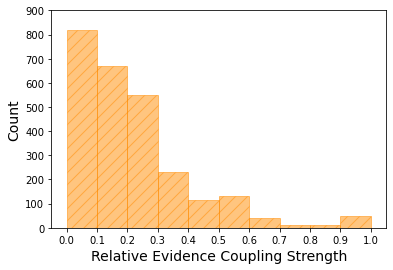

In [40]:
bins = np.linspace(0,1,11)  # fixed number of bins
plt.xlabel('Relative Evidence Coupling Strength',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.ylim([0,900])
plt.xticks(ticks=bins)
plt.hist(coupling_strength['ratio'], bins=bins, color='darkorange', edgecolor='darkorange', linewidth=1, histtype='bar', alpha=0.5, hatch="//")

In [53]:
threshold_p = 0.3

sufficient_overlap = coupling_strength[coupling_strength['ratio'] > threshold_p]
sufficient_overlap_nodes = list(set(sufficient_overlap['node_1']).union(set(sufficient_overlap['node_2'])))

unique_nodes = list(set(g.vs.indices).difference(set(sufficient_overlap_nodes)))

sufficient_overlap_nodes = g.vs.select(sufficient_overlap_nodes)
unique_nodes = g.vs.select(unique_nodes)

In [54]:
# visualization [any updates need to be here]
sufficient_overlap_nodes['color'] = 'light blue'
unique_nodes['color'] = 'pink'
plot(g, margin=50,bbox=(600,600),layout='kk').show()

In [59]:
# print nodes names
for node in unique_nodes:
    print(node['name'],node['Year'],node['outcome'])

Mossner 2001 Positive
Caspi 2003 Positive
Lotrich 2008 Unclear
Kraus 2007 Negative
Comasco_b 2011 Unclear
Wichers 2007 Negative
Uher 2011 Negative
Mitchell 2011 Negative


In [60]:
# print out paper with low ratio between real and expected citation counts
for node in idx_low:
    print(g.vs[node]['name'],g.vs[node]['Year'],g.vs[node]['outcome'])

Mossner 2001 Positive
Dick 2007 Unclear
Kraus 2007 Negative
Kilpatrick 2007 Unclear
Lotrich 2008 Unclear
Aguilera 2009 Positive
Benjet 2009 Positive
Hammen 2009 Unclear
